In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# !rm -rf /kaggle/working/*

In [3]:
import cv2 as cv
import tensorflow as tf
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Model
from keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import SGD,Adam
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense
from keras.layers import Dropout, Lambda, Input,Softmax
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

2024-04-17 16:53:30.357048: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 16:53:30.357148: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 16:53:30.490867: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import os
data_dir = "/kaggle/input/brain-tumor-data"
train_dir='/kaggle/input/brain-tumor-data/kaggle/working/actual_train_data'
test_dir='/kaggle/input/brain-tumor-data/kaggle/working/test_data'
validation_dir = '/kaggle/input/brain-tumor-data/kaggle/working/validation_data'
# os.makedirs(train_dir, exist_ok=True)
# os.makedirs(test_dir, exist_ok=True)

# # Splitting data into training and testing sets (80% training, 20% testing)
# for category in os.listdir(data_dir):
#     category_path = os.path.join(data_dir, category)
#     if os.path.isdir(category_path):
#         images = os.listdir(category_path)
#         train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

#         for image in train_images:
#             src = os.path.join(category_path, image)
#             dst = os.path.join(train_dir, category)
#             os.makedirs(dst, exist_ok=True)
#             shutil.copy(src, dst)

#         for image in test_images:
#             src = os.path.join(category_path, image)
#             dst = os.path.join(test_dir, category)
#             os.makedirs(dst, exist_ok=True)
#             shutil.copy(src, dst)

In [5]:
# import os
# import shutil
# from sklearn.model_selection import train_test_split
# actual_train_dir='/kaggle/working/actual_train_data'
# os.makedirs(validation_dir, exist_ok=True)
# os.makedirs(actual_train_dir, exist_ok=True)

# # Splitting data into actual_training and testing sets (70% training, 10% validation) out of 80 % of training
# for category in os.listdir(train_dir):
#     category_path = os.path.join(train_dir, category)
#     if os.path.isdir(category_path):
#         images = os.listdir(category_path)
#         train_images, val_images = train_test_split(images, test_size=0.125, random_state=42)

#         for image in train_images:
#             src = os.path.join(category_path, image)
#             dst = os.path.join(actual_train_dir, category)
#             os.makedirs(dst, exist_ok=True)
#             shutil.copy(src, dst)


#         for image in val_images:
#             src = os.path.join(category_path, image)
#             dst = os.path.join(validation_dir, category)
#             os.makedirs(dst, exist_ok=True)
#             shutil.copy(src, dst)

In [6]:

img_width, img_height = 200, 200  #input images are 200x200 grayscale
batch_size = 42
# Create data generators with augmentation for train and test data
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='grayscale',  #gray scale images thats why
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 7124 images belonging to 4 classes.
Found 1020 images belonging to 4 classes.


In [7]:
sequential_model = Sequential([
    Input(shape=(200, 200, 1)),
    Conv2D(64, (5, 5), activation='relu',padding='same'),
    MaxPooling2D((2, 2),padding='same'),
    BatchNormalization(),
    Conv2D(128, (5, 5), activation='relu',padding='same'),
    MaxPooling2D((2, 2),padding='same'),
    BatchNormalization(),
    Conv2D(128, (5, 5), activation='relu',padding='same'),
    MaxPooling2D((2, 2),padding='same'),
    BatchNormalization(),
    Conv2D(256, (5, 5), activation='relu',padding='same'),
    MaxPooling2D((2, 2),padding='valid'),
    BatchNormalization(),
    Conv2D(256, (5, 5), activation='relu',padding='same'),
    MaxPooling2D((2, 2),padding='same'),
    BatchNormalization(),
    Conv2D(512, (5, 5), activation='relu',padding='same'),
    MaxPooling2D((2, 2),padding='same'),
    BatchNormalization(),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(4,'softmax')
])

sequential_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 64)   │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 128)  │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 25, 25, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 6, 512)      │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 3, 3, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,80

 Total params: 11,733,892 (44.76 MB)

 Trainable params: 11,731,204 (44.75 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [8]:
learning_rate = 0.01
sgd_optimizer = SGD(learning_rate=learning_rate,momentum=0.9)

sequential_model.compile(optimizer=sgd_optimizer, 
loss='categorical_crossentropy',
metrics=['accuracy'])

In [9]:

checkpoint = callbacks.ModelCheckpoint(
    'model_parameters_1.keras', 
    save_best_only=True, 
    monitor='val_accuracy',
    mode='max',
    verbose=1)

# Training the model with saving the best trained model in terms of accuracy
history = sequential_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[ checkpoint]
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/170 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.2917 - loss: 1.5574   

I0000 00:00:1713372855.154391      83 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713372855.179937      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 97/170 ━━━━━━━━━━━━━━━━━━━━ 22s 313ms/step - accuracy: 0.5707 - loss: 1.1325

W0000 00:00:1713372885.106838      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.6129 - loss: 1.0160

W0000 00:00:1713372896.667001      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.32059, saving model to model_parameters_1.keras


W0000 00:00:1713372902.501432      83 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


170/170 ━━━━━━━━━━━━━━━━━━━━ 74s 282ms/step - accuracy: 0.6134 - loss: 1.0147 - val_accuracy: 0.3206 - val_loss: 2.6710
Epoch 2/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7874 - loss: 0.5168
Epoch 2: val_accuracy improved from 0.32059 to 0.48725, saving model to model_parameters_1.keras
170/170 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.7876 - loss: 0.5166 - val_accuracy: 0.4873 - val_loss: 1.9887
Epoch 3/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8648 - loss: 0.3477
Epoch 3: val_accuracy improved from 0.48725 to 0.84804, saving model to model_parameters_1.keras
170/170 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.8648 - loss: 0.3475 - val_accuracy: 0.8480 - val_loss: 0.3584
Epoch 4/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9199 - loss: 0.2213
Epoch 4: val_accuracy improved from 0.84804 to 0.90980, saving model to model_parameters_1.keras
170/170 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - accuracy: 0.9199 - loss: 0.2212 - val_accurac

In [10]:
img_width, img_height = 200, 200
batch_size = 42
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
    
)

Found 2039 images belonging to 4 classes.


In [11]:
score = sequential_model.evaluate(test_generator)
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 228ms/step - accuracy: 0.9773 - loss: 0.1270
Test Loss: 0.1027347669005394
Test Accuracy: 0.9823442697525024


W0000 00:00:1713373184.987188      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


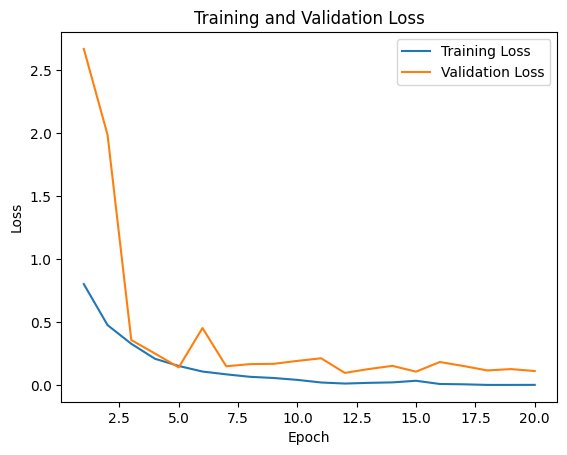

In [12]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting training and validation loss over epochs
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

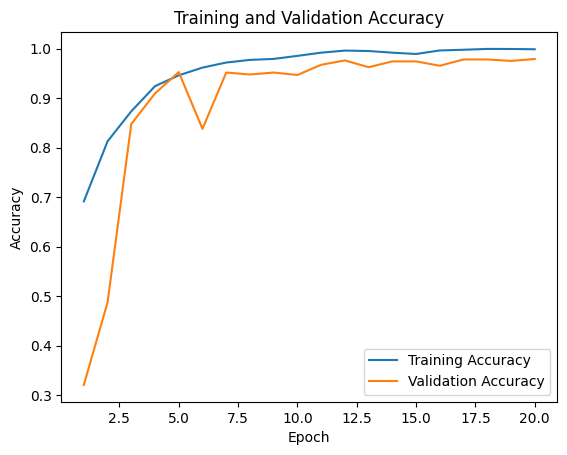

In [13]:
# Assuming 'history' is the variable storing the training history
train_accuracy = history.history['accuracy']  # Replace 'accuracy' with your actual metric name
val_accuracy = history.history['val_accuracy']  # Replace 'val_accuracy' with your actual metric name

# Plotting training and validation accuracy over epochs
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
predictions=sequential_model.predict(test_generator)
predictions

 5/49 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step

W0000 00:00:1713373188.774799      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step


W0000 00:00:1713373192.150146      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


array([[1.0000000e+00, 5.7125953e-12, 2.0476767e-14, 2.5557654e-13],
       [1.0000000e+00, 4.8483946e-15, 7.5254990e-19, 7.1700763e-17],
       [9.9926192e-01, 7.2966056e-04, 1.4801957e-06, 7.0246288e-06],
       ...,
       [3.5520765e-15, 3.8621966e-12, 5.8903411e-18, 1.0000000e+00],
       [7.0232899e-12, 2.9745204e-10, 7.7147358e-16, 1.0000000e+00],
       [8.2312476e-21, 3.1708698e-17, 7.3161509e-25, 1.0000000e+00]],
      dtype=float32)

In [15]:
predict_=np.argmax(predictions,axis=1)
tr=test_generator.classes
tr

array([0, 0, 0, ..., 3, 3, 3], dtype=int32)

In [16]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
accuracy_score(tr,predict_)

0.9823442864149092

In [17]:
sequential_model.save("/kaggle/working/model_09_04.h5")

In [18]:
# !zip -r file.zip "/kaggle/working"

In [19]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
cls=classification_report(tr,predict_)
print(cls)

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       510
           1       0.97      0.98      0.98       517
           2       0.98      0.99      0.98       480
           3       0.99      1.00      1.00       532

    accuracy                           0.98      2039
   macro avg       0.98      0.98      0.98      2039
weighted avg       0.98      0.98      0.98      2039



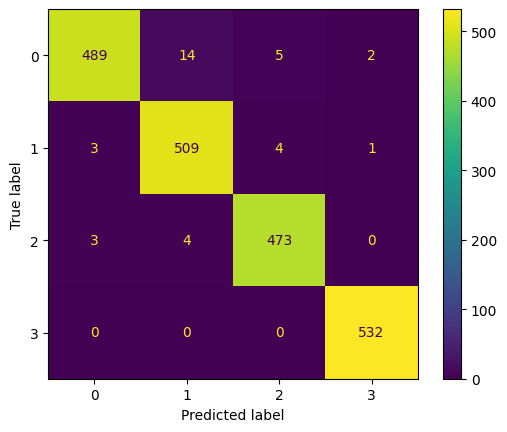

In [20]:
cm=confusion_matrix(tr,predict_)
cmm=ConfusionMatrixDisplay(cm)
cmm.plot()
plt.show()